### **Загрузка датасета и обработка данных**

Датасет был предварительно обработан: удалены полузаполненные столбцы и пустые строки.

Чтобы после каждого завершения сессии не исчезал файл с датасетом, он был загружен на **Google Drive**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Заполним пропуски средним значением по столбцу:

In [ ]:
import pandas as pd


df = pd.read_csv("drive/MyDrive/DigitalBreakthrough/clean.csv").drop('Unnamed: 0', axis=1)
df = df.fillna(df.mean(numeric_only=True))

text_features = ['name', 'district', 'subject', 'region_x']  # useful variable


### **Поиск корреляций**

Рассмотрим попарные корреляции целевого столбца с остальными:

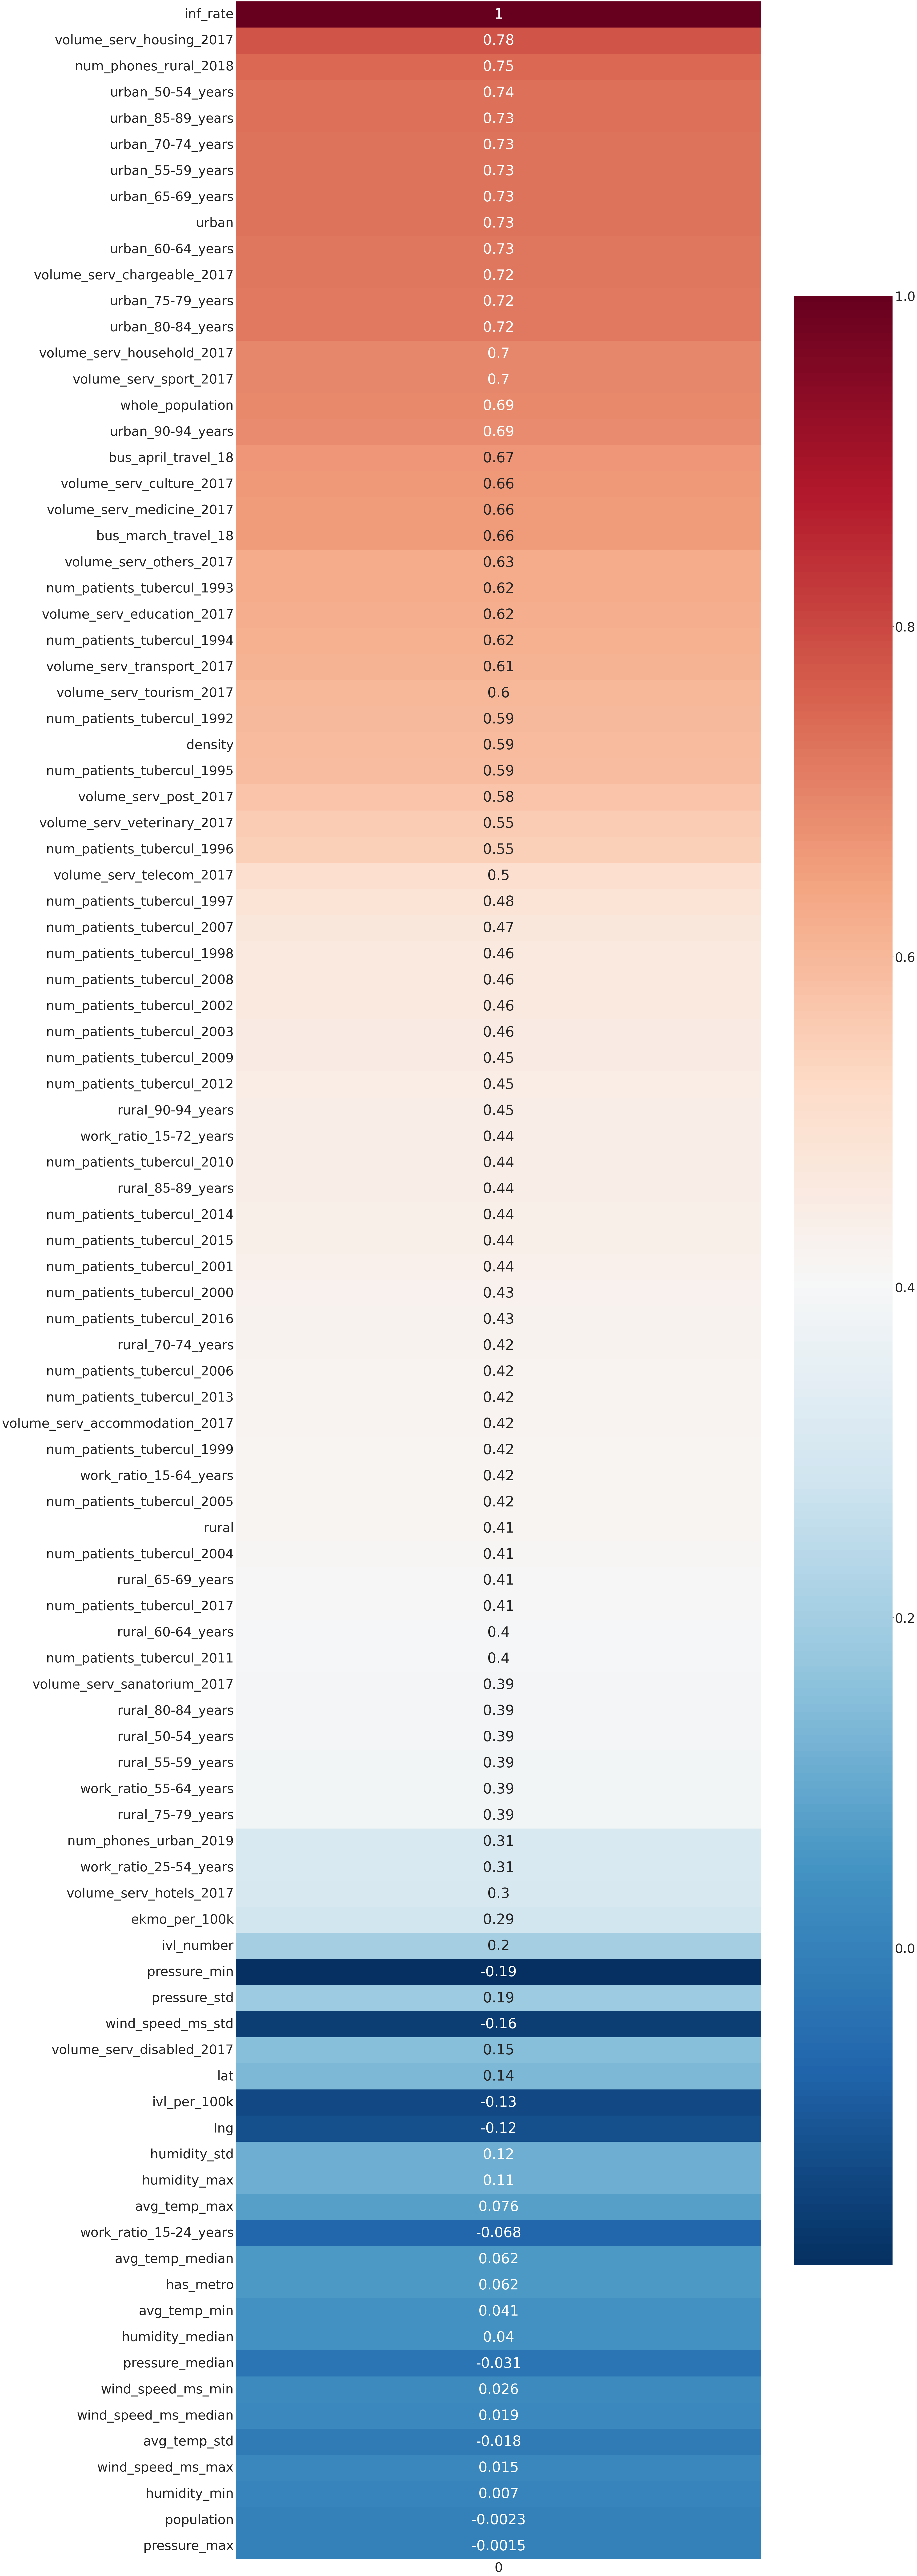

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(font_scale=5)
plt.figure(figsize=(50, 200))

sns.heatmap(pd.DataFrame(df.corrwith(df['inf_rate']).sort_values(
    key=lambda x: abs(x), ascending=False)), annot=True,
    cmap=sns.color_palette("RdBu_r", 1000))


Рассмотрим также коэффиценты корреляции Спирмена

<Figure size 720x720 with 0 Axes>

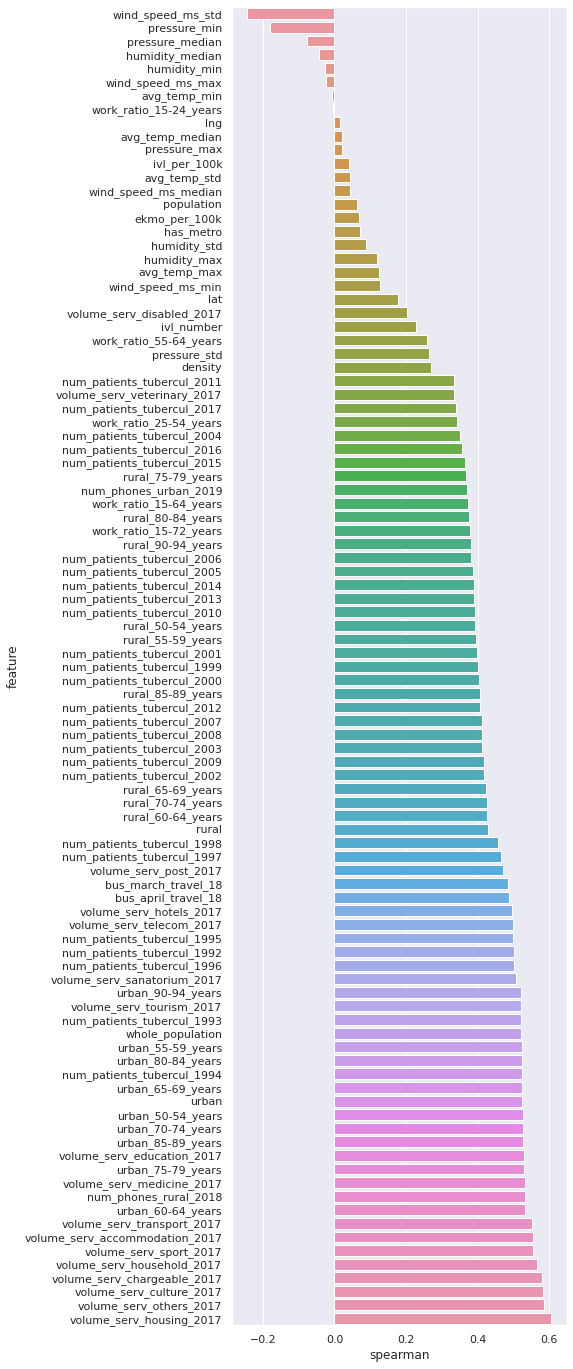

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(10, 10))


def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['inf_rate'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')


features = df.columns.drop(text_features + ['inf_rate'])
spearman(df, features)

### **Делим датасет на данные для обучения и для проверки**

In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop(text_features + ['inf_rate'], axis = 1)
y = df['inf_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)


### **Обучение**

Библиотека CatBoost использует градиентный бустинг. Кроме того, использована защита от переобучения, встроенная в эту библиотеку.

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, Pool


eval_pool = Pool(X_test, y_test)
model = CatBoostRegressor(iterations=1000, learning_rate=0.1,
                          eval_metric='MAE', custom_metric='MAE',
                          loss_function='MAE')

model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=eval_pool)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
0:	learn: 0.6852148	test: 0.6521945	best: 0.6521945 (0)	total: 58.2ms	remaining: 58.1s
1:	learn: 0.6433333	test: 0.6182375	best: 0.6182375 (1)	total: 66.4ms	remaining: 33.1s
2:	learn: 0.5938325	test: 0.5671038	best: 0.5671038 (2)	total: 74.5ms	remaining: 24.7s
3:	learn: 0.5465023	test: 0.5280495	best: 0.5280495 (3)	total: 82ms	remaining: 20.4s
4:	learn: 0.5095903	test: 0.4995995	best: 0.4995995 (4)	total: 89.5ms	remaining: 17.8s
5:	learn: 0.4853057	test: 0.4750191	best: 0.4750191 (5)	total: 97ms	remaining: 16.1s
6:	learn: 0.4637214	test: 0.4581344	best: 0.4581344 (6)	total: 105ms	remaining: 14.8s
7:	learn: 0.4351160	test: 0.4387442	best: 0.4387442 (7)	total: 112ms	remaining: 13.9s
8:	learn: 0.4050191	test: 0.4082178	best: 0.4082178 (8)	total: 120ms	remaining: 13.2s
9:	learn: 0.3797506	test: 0.3879950	best: 0.3879950 (9)	total: 127m

Значение MAE:

In [ ]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(X_test)
mean_absolute_error(preds, y_test)

0.017976977094986246

### **Выгрузка модели и дальнейшее использовании в Telegram-боте**

Сохраним модель для дальнейшего использования в Telegram-боте.

In [ ]:
model.save_model('model.cbm')

Следующую функцию можно будет использовать в коде бота.

In [ ]:
def get_city_prediction(city_name: str) -> (float, float, float):
    row = df.loc[df['name'] == city_name]
    prediction = round(model.predict(row.drop(text_features + ['inf_rate'],
                                              axis=1))[0], 10)
    real = round(float(row.inf_rate), 10)
    return prediction, real, abs(prediction - real)


get_city_prediction('Калининград')


(2.3054097249, 2.302585093, 0.002824631900000263)